In [77]:
import pandas as pd
from pathlib import Path
import parse
from collections import deque

base_path = Path("./output")
timing_fmt_matcher = parse.compile("lat{latency:d}_var{variance:d}_corr{corr:d}")
exp_fmt_matcher = parse.compile("{model_name}_{rep:d}_of_{total_reps:d}")

dfs = deque()

for exp_dir in base_path.iterdir():
    res = timing_fmt_matcher.parse(exp_dir.name)
    one_way_latency = res["latency"]
    one_way_variance = res["variance"]
    one_way_corr = res["corr"]
    lat_var = f"lat{one_way_latency:04d}ms_var{one_way_variance:04d}ms"
    for rep_dir in exp_dir.iterdir():
        res = exp_fmt_matcher.parse(rep_dir.name)
        model = res["model_name"]
        rep = res["rep"]
        
        steps_file = rep_dir / "client.steps.csv"
        steps_csv = pd.read_csv(steps_file)
        
        steps_csv["one_way_latency"] = one_way_latency
        steps_csv["one_way_variance"] = one_way_variance
        steps_csv["model"] = model
        steps_csv["rep"] = rep
        steps_csv["one_way_corr"] = one_way_corr
        steps_csv["lat_var"] = lat_var
        
        dfs.append(steps_csv)
    
data = pd.concat(dfs, ignore_index=True)
data["task_duration"] = data.groupby(["one_way_latency", "one_way_variance", "one_way_corr", "model", "rep"])["step_duration"].cumsum()
lat_var = pd.CategoricalDtype(sorted(data["lat_var"].unique()), ordered=True)
data["lat_var"] = data["lat_var"].astype(lat_var)
data

,step_number,step_start,step_start_monotonic,step_end,step_end_monotonic,first_frame_monotonic,last_frame_monotonic,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,one_way_latency,one_way_variance,model,rep,one_way_corr,lat_var,task_duration
0,0,1.715994e+09,263738.948506,1.715994e+09,263740.260528,263738.949561,263738.949561,1.310967,0.000000,1.312022,1.312022,0.001056,1,100,20,first-order-median,6,0,lat0100ms_var0020ms,1.312022
1,1,1.715994e+09,263740.260528,1.715994e+09,263746.158942,263740.263091,263745.539104,0.619838,5.230947,5.898414,0.667467,0.047629,19,100,20,first-order-median,6,0,lat0100ms_var0020ms,7.210436
2,2,1.715994e+09,263746.158942,1.715994e+09,263752.311376,263746.161966,263751.633897,0.677479,5.230947,6.152435,0.921487,0.244008,13,100,20,first-order-median,6,0,lat0100ms_var0020ms,13.362871
3,3,1.715994e+09,263752.311376,1.715994e+09,263758.305689,263752.313255,263757.713409,0.592280,5.230947,5.994312,0.763365,0.171086,11,100,20,first-order-median,6,0,lat0100ms_var0020ms,19.357183
4,4,1.715994e+09,263758.305689,1.715994e+09,263764.400132,263758.307348,263763.814831,0.585301,5.230947,6.094443,0.863496,0.278195,13,100,20,first-order-median,6,0,lat0100ms_var0020ms,25.451626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,46,1.715926e+09,196382.817530,1.715926e+09,196387.413530,196382.818729,196386.899198,0.514332,4.049000,4.595999,0.546999,0.032667,15,50,10,legacy,6,0,lat0050ms_var0010ms,215.104562
45896,47,1.715926e+09,196387.413530,1.715926e+09,196392.237547,196387.414592,196391.715969,0.521578,4.049000,4.824017,0.775017,0.253439,16,50,10,legacy,6,0,lat0050ms_var0010ms,219.928579
45897,48,1.715926e+09,196392.237547,1.715926e+09,196396.843498,196392.238668,196396.344372,0.499126,4.049000,4.605951,0.556951,0.057825,16,50,10,legacy,6,0,lat0050ms_var0010ms,224.534530
45898,49,1.715926e+09,196396.843498,1.715926e+09,196401.557479,196396.844844,196401.009401,0.548077,4.049000,4.713981,0.664981,0.116904,14,50,10,legacy,6,0,lat0050ms_var0010ms,229.248511


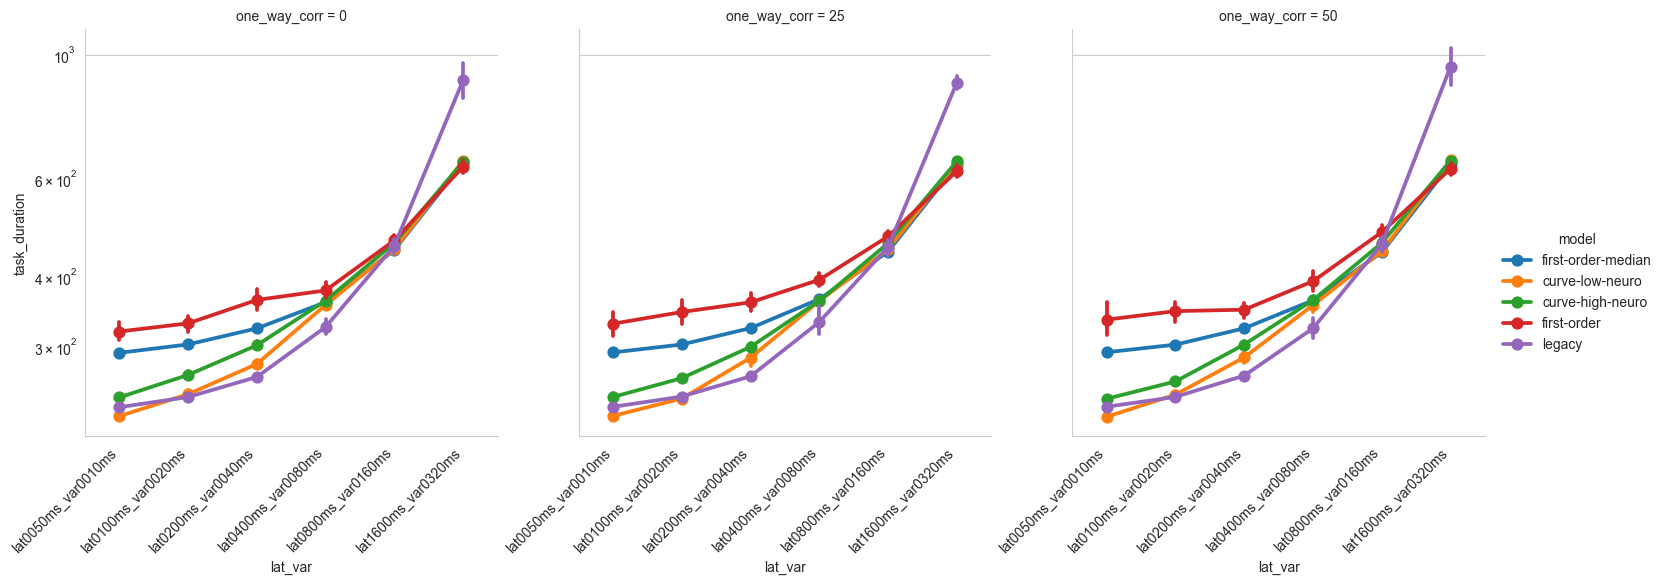

,step_number,step_start,step_start_monotonic,step_end,step_end_monotonic,first_frame_monotonic,last_frame_monotonic,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,one_way_latency,one_way_variance,model,rep,one_way_corr,lat_var,task_duration
50,50,1.715994e+09,264035.409427,1.715994e+09,264041.495356,264035.410412,264040.891388,0.603968,5.230947,6.085929,0.854982,0.251013,15,100,20,first-order-median,6,0,lat0100ms_var0020ms,302.546850
101,50,1.715998e+09,267334.986902,1.715998e+09,267339.687980,267334.988121,267339.012914,0.675067,3.800554,4.701078,0.900524,0.225458,10,100,20,curve-low-neuro,8,0,lat0100ms_var0020ms,251.236891
152,50,1.715996e+09,265717.367255,1.715996e+09,265722.323294,265717.368293,265721.651788,0.671506,4.271826,4.956039,0.684213,0.012707,13,100,20,curve-high-neuro,7,0,lat0100ms_var0020ms,270.756009
203,50,1.715988e+09,258180.882917,1.715988e+09,258186.515612,258180.884129,258185.850886,0.664725,4.821638,5.632694,0.811057,0.146331,13,100,20,first-order,2,0,lat0100ms_var0020ms,342.123283
254,50,1.715993e+09,262925.301060,1.715993e+09,262930.287277,262925.302276,262929.661378,0.625900,4.244268,4.986218,0.741950,0.116050,13,100,20,curve-high-neuro,5,0,lat0100ms_var0020ms,259.086309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45695,50,1.715927e+09,197473.283689,1.715927e+09,197477.505686,197473.284491,197476.999481,0.506204,3.678404,4.221997,0.543593,0.037389,14,50,10,curve-low-neuro,6,0,lat0050ms_var0010ms,225.590753
45746,50,1.715931e+09,201170.302780,1.715931e+09,201174.803632,201170.303987,201174.318411,0.485221,3.995970,4.500852,0.504882,0.019662,17,50,10,curve-high-neuro,9,0,lat0050ms_var0010ms,241.292659
45797,50,1.715933e+09,202741.189501,1.715933e+09,202745.557490,202741.190363,202744.986445,0.571045,3.658837,4.367989,0.709153,0.138107,9,50,10,curve-low-neuro,10,0,lat0050ms_var0010ms,224.223433
45848,50,1.715925e+09,194848.620557,1.715925e+09,194852.880562,194848.621346,194852.384135,0.496427,3.628960,4.260005,0.631044,0.134618,17,50,10,curve-low-neuro,4,0,lat0050ms_var0010ms,224.660614


In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

last_step_data = data[data["step_number"] == data["step_number"].max()]

fg = sns.catplot(kind="point", data=last_step_data, x="lat_var", y="task_duration", col="one_way_corr", hue="model")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

fg.set(yscale="log")
plt.show()
last_step_data

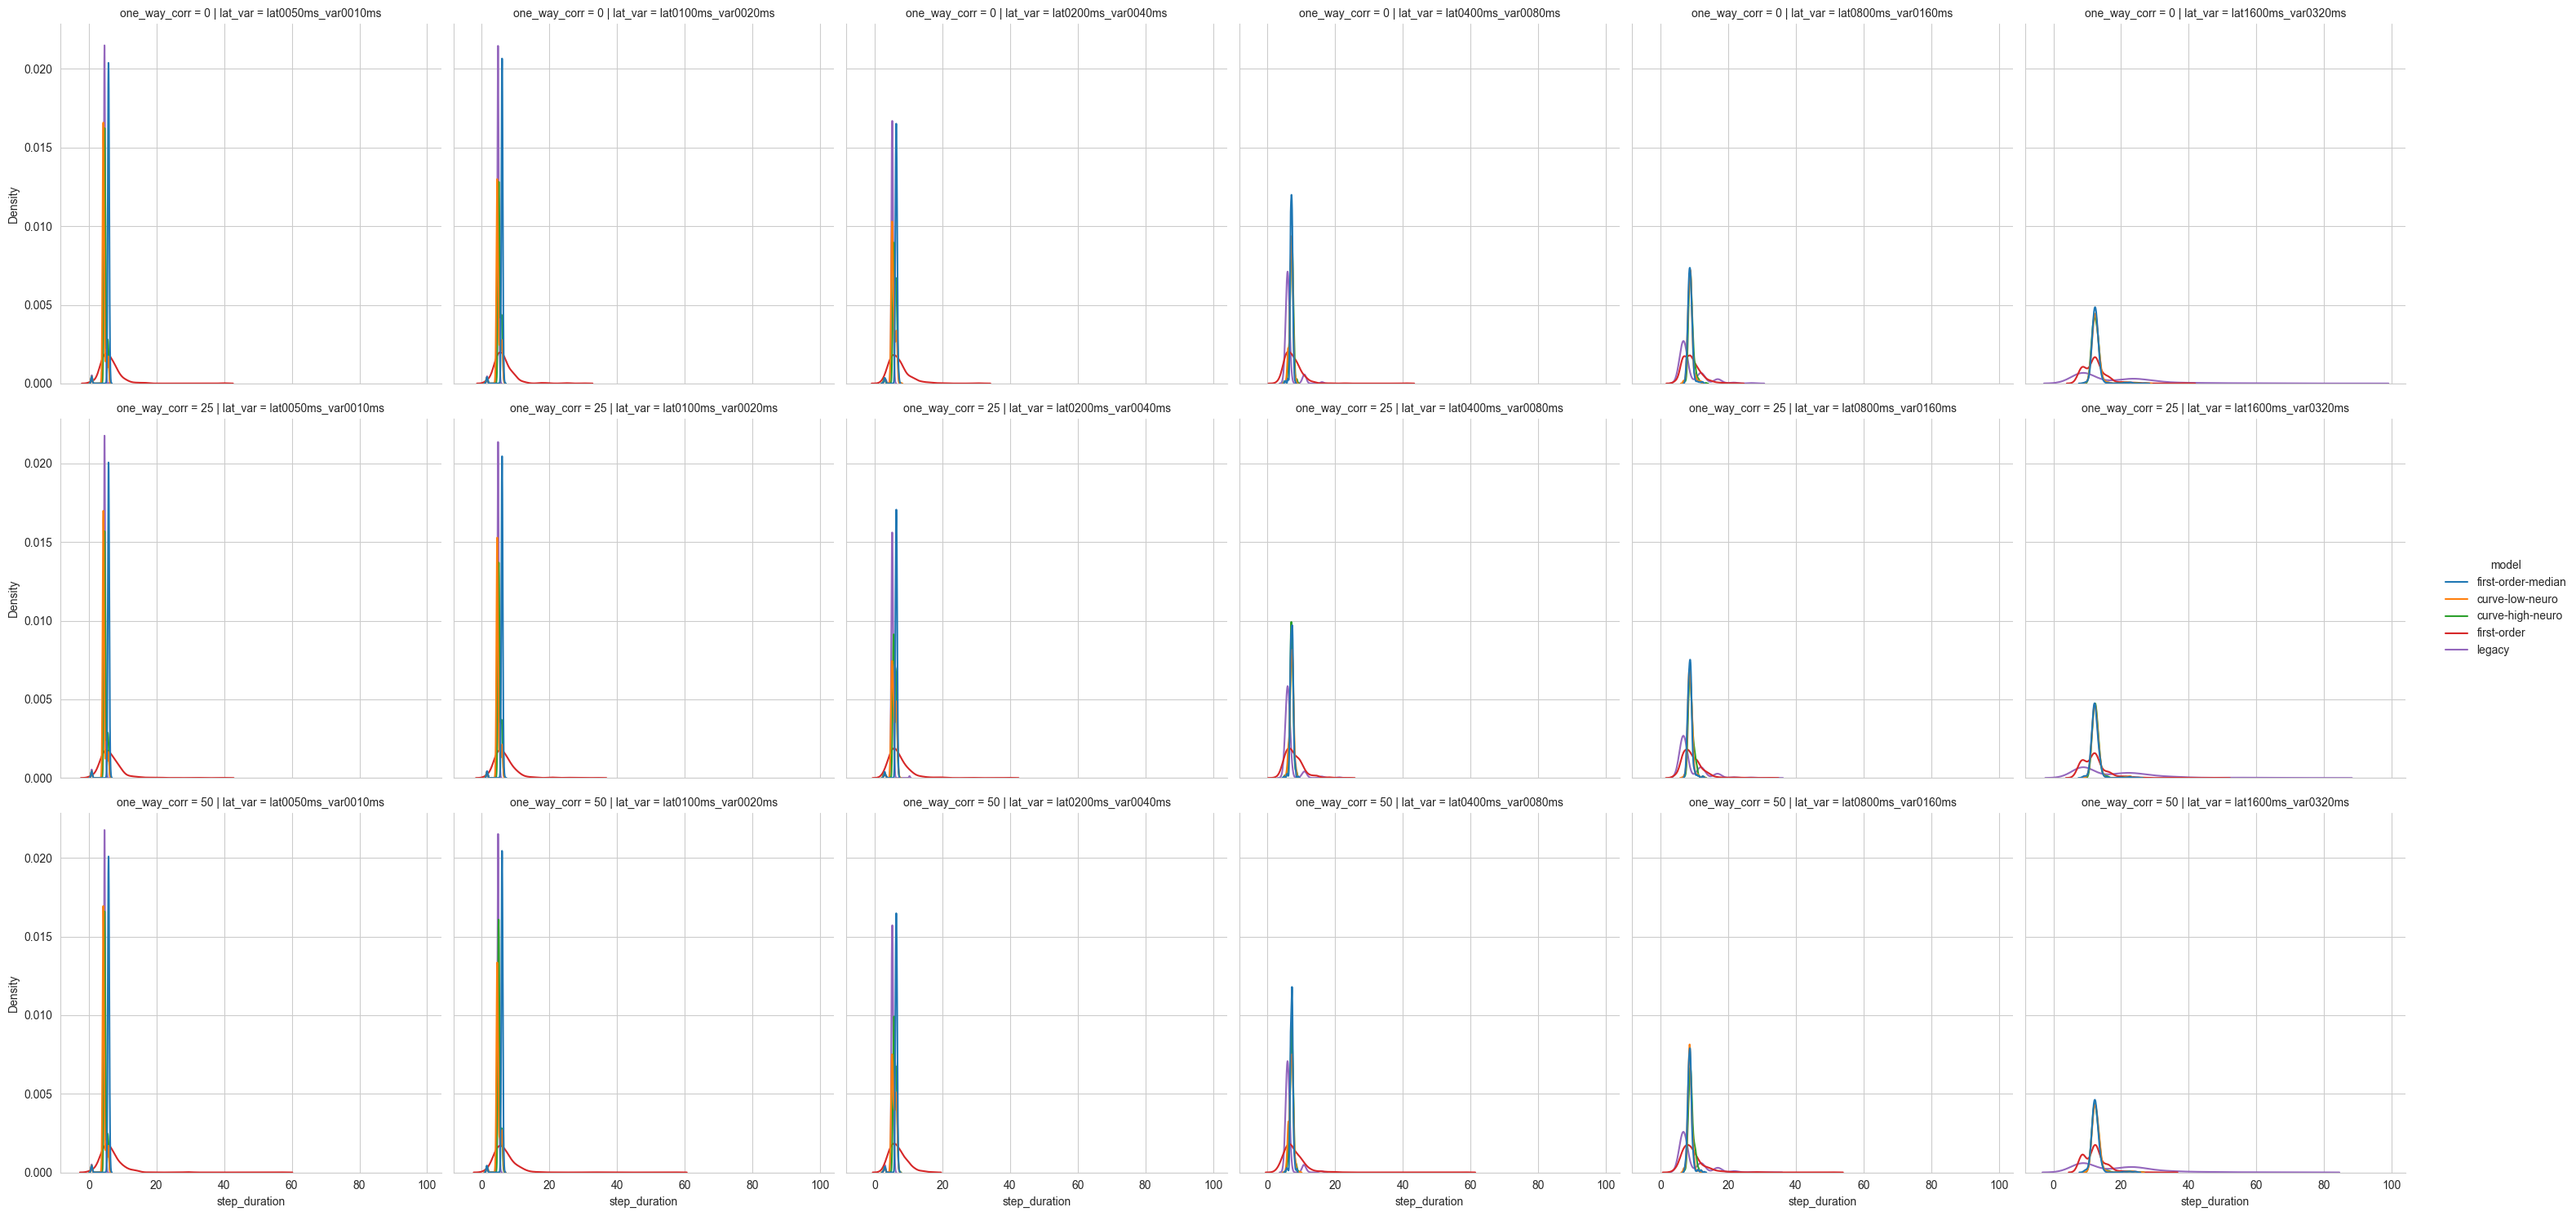

In [79]:
fg = sns.displot(data=data, kind="kde", x="step_duration", hue="model", col="lat_var", row="one_way_corr", legend=True)
# fg.set(xscale="log")
plt.show()

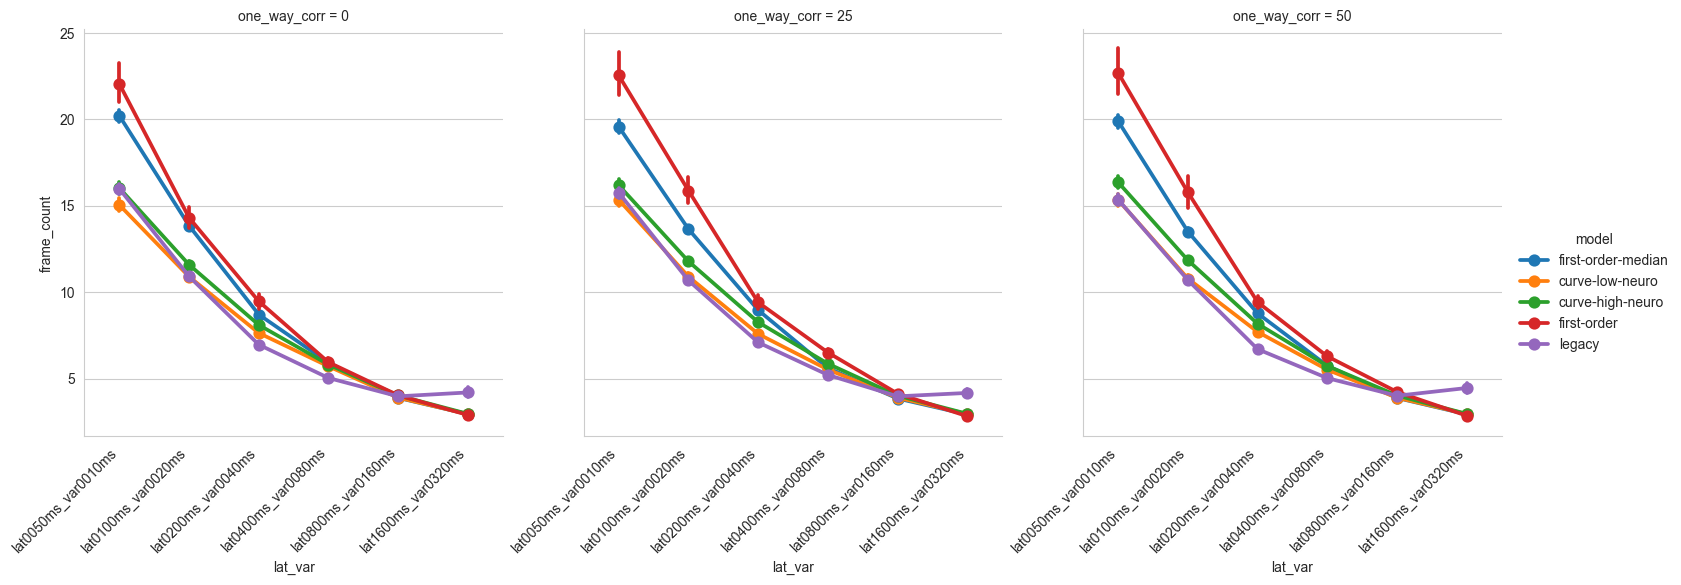

In [80]:
fg = sns.catplot(kind="point", data=data, x="lat_var", y="frame_count", col="one_way_corr", hue="model")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()